# Price Prediction

Building an api for Predicting the Price of Diamonds for the Month 1

## Loading

In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset_path = "../../datasets/diamonds/diamonds-month-1.csv"

In [3]:
df = pd.read_csv(dataset_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17801 entries, 0 to 17800
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    17801 non-null  float64
 1   cut      17801 non-null  object 
 2   color    17801 non-null  object 
 3   clarity  17801 non-null  object 
 4   depth    17801 non-null  float64
 5   table    17801 non-null  float64
 6   price    17801 non-null  int64  
 7   x        17801 non-null  float64
 8   y        17801 non-null  float64
 9   z        17801 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.4+ MB


## Transform

In [5]:
## Domain Knowledge ->  Ordered Data. Not used currently in the model.
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1','SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

In [6]:
# List all column names for numeric features
NUMERIC_FEATURES = ["carat", "depth", "table", "x", "y", "z"]
# List all column names for categorical features
CATEGORICAL_FEATURES = ["cut", "color", "clarity"]
# List Target
TARGET = "price"

## Preprocess

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [8]:
# Create Numeric Transformer
numeric_transformer = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]
    )

In [9]:
# Create Categorical Transformer
categorical_transformer = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("encode", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

In [10]:
# Create Preprocess Encoder
preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", numeric_transformer, NUMERIC_FEATURES),
            ("categorical", categorical_transformer, CATEGORICAL_FEATURES),
        ],
        remainder="drop",
        n_jobs=-1,
    )

## Splitting

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X, y = df.drop(columns=[TARGET]), df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

In [13]:
X_train.size, y_train.size, X_test.size, y_test.size

(128160, 14240, 32049, 3561)

## Model Building

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [15]:
regressor = RandomForestRegressor(n_estimators = 300, max_depth = 8,
                random_state = 42)

In [16]:
model = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    )

In [17]:
## Do Cross Validation
score = cross_val_score(model, X_train, y_train, 
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
score

-417.03605992700875

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, n_estimators=300,
                                       random_state=42))])

## Evaluate on Test Data

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

Predict using the model and a basic average baseline

In [20]:
y_pred = model.predict(X_test)
y_baseline = np.mean(y_test)

In [21]:
dfTest = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
dfTest["y_base"] = np.mean(y_test)

In [22]:
dfTest.head()

,y_test,y_pred,y_base
12432,1877,2090.990561,2417.388936
14390,684,642.968398,2417.388936
11655,4418,4768.045765,2417.388936
14952,959,983.831996,2417.388936
9376,912,881.911042,2417.388936


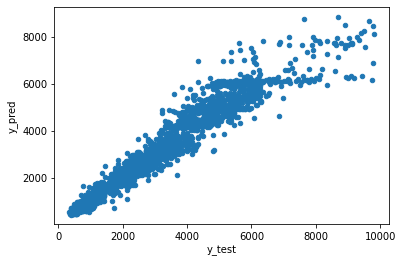

In [24]:
dfTest.plot.scatter("y_test", "y_pred");

In [25]:
# Calculate Test Metrics
rmseTest = np.sqrt(mean_squared_error(dfTest.y_test, dfTest.y_pred))
r2Test = r2_score(dfTest.y_test, dfTest.y_pred)

In [26]:
# Calculate Baseline Metrics
rmseBase = np.sqrt(mean_squared_error(dfTest.y_test, dfTest.y_base))
r2Base = r2_score(dfTest.y_test, dfTest.y_base)

In [27]:
print("Scoring")
print("RMSE - Test: ", rmseTest)
print("RMSE - Baseline: ", rmseBase)
print("R2 - Test: ", r2Test)
print("R2 - Test: ", r2Base)

Scoring
RMSE - Test:  401.4005568781394
RMSE - Baseline:  1897.991898542188
R2 - Test:  0.955273261259279
R2 - Test:  0.0
